# A mesh class for a tesseroid relief 

There is a `PrismRelief` mesh class in [Fatiando a Terra](http://www.fatiando.org/) but we still need a `TesseroidRelief` for this inversion. This is a mesh of tesseroids distributed along an area. They ondulate below and above a reference level, describing the relief of an interface. Tesseroids have either the top of bottom fixed to a reference height. The other end ondulates along a relief.

The `TesseroidRelief` class is defined in the [`tesseroid_mesh.py`](tesseroid_mesh.py) file.

This notebook will show some of the features of the mesh and how to use it.

## Package imports

In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import multiprocessing
import seaborn  # Makes the default style of the plots nicer

In [3]:
from fatiando import gridder, utils
from fatiando.vis import myv
from fatiando.gravmag import tesseroid
import fatiando

In [4]:
print("Using Fatiando a Terra version: {}".format(fatiando.__version__))

Using Fatiando a Terra version: 3aed3f5676a45705b598bfc72f9883043097c854


In [5]:
from tesseroid_mesh import TesseroidRelief

## Create some synthetic relief

Define a regular grid.

In [6]:
# shape is nlat, nlon = the number of points in the grid
shape = (41, 31)
# Make a regular grid inside an area = (s, n, w, e)
area = (20, 60, -40, 40)
lat, lon, h = gridder.regular(area, shape, z=250e3)

The model area is slightly larger because the points generated above are in the center of each cell.

In [7]:
dlat, dlon = gridder.spacing(area, shape)
s, n, w, e = area
modelarea = (s - dlat/2, n + dlat/2, w - dlon/2, e + dlon/2)

Make a checker board relief undulating along a specified height reference.

In [8]:
f = 0.2
reference = -35e3
relief = 10e3*np.sin(0.5*f*lon)*np.cos(f*lat) + reference

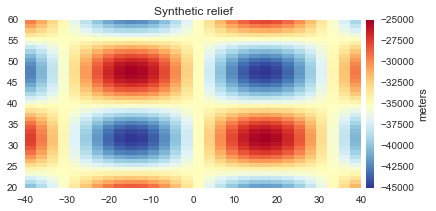

In [9]:
plt.figure(figsize=(7, 3))
plt.title('Synthetic relief')
plt.axis('scaled')
plt.pcolormesh(lon.reshape(shape), lat.reshape(shape), relief.reshape(shape),
               cmap="RdYlBu_r")
plt.colorbar(pad=0.01).set_label('meters')
plt.xlim(lon.min(), lon.max())
plt.ylim(lat.min(), lat.max())
plt.tight_layout()

Set a density contrast for the relief. The density contrast is negative if the relief is below the reference and positive otherwise.

In [10]:
density = 600*np.ones_like(relief)
density[relief < reference] *= -1

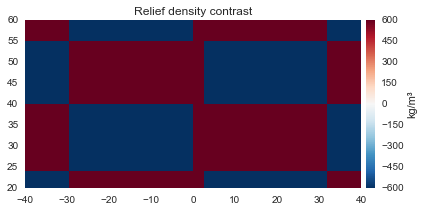

In [11]:
plt.figure(figsize=(7, 3))
plt.title('Relief density contrast')
plt.axis('scaled')
plt.pcolormesh(lon.reshape(shape), lat.reshape(shape), density.reshape(shape),
               cmap="RdBu_r")
plt.colorbar(pad=0.01).set_label(u'kg/m³')
plt.xlim(lon.min(), lon.max())
plt.ylim(lat.min(), lat.max())
plt.tight_layout()

Now we can create a mesh and make a 3D plot of it.

In [12]:
sample_mesh = TesseroidRelief(modelarea, shape, relief, reference, {'density': density})

In [13]:
def plot_result_3d(moho, fname):
    bounds = modelarea + (-20e3, -60e3)
    scale = (1, 1, 40) # Exaggerate the radial dimension
    datarange = np.abs([moho.props['density'].max(), moho.props['density'].min()]).max()
    scene = myv.figure(zdown=False)
    plot = myv.tesseroids(moho, 'density', scale=scale)
    plot.module_manager.scalar_lut_manager.show_legend = True
    plot.module_manager.scalar_lut_manager.lut_mode = 'RdYlBu'
    plot.module_manager.scalar_lut_manager.data_range = [-datarange, datarange]
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.minimum_size = np.array([1, 1])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position2 = np.array([ 0.13741855,  0.64385382])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position = np.array([ 0.03303258,  0.07342193])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.maximum_size = np.array([100000, 100000])
    plot.module_manager.scalar_lut_manager.label_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.title_text_property.color = (0, 0, 0)
    scene.scene.camera.position = [2252864.9143914036, -5202911.2574882135, 8495162.9722945951]
    scene.scene.camera.focal_point = [3135763.9476126051, 1056258.4985192744, 829277.18542720564]
    scene.scene.camera.view_angle = 30.0
    scene.scene.camera.view_up = [0.6164057832087273, 0.57367112225287575, 0.53939350563383837]
    scene.scene.camera.clipping_range = [783483.44437851617, 16078402.004277557]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()
    myv.savefig(fname)
    #myv.show()
    myv.mlab.close()
    return Image(filename=fname)    

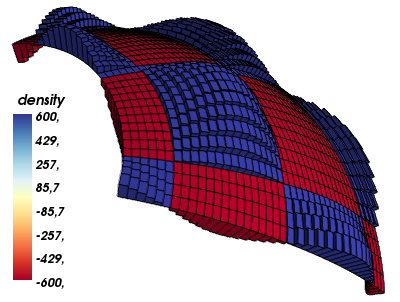

In [14]:
plot_result_3d(sample_mesh, 'example-mesh.png')

## Calculate the gravity effect of this mesh

The mesh behaves like a list of `Tesseroid` objects. So we can pass it to any function in Fatiando a Terra that takes such list as input.

Below, we'll show an example of using the forward modeling functions in Fatiando to calculate the gravitational effect of the above relief.

In [15]:
ncpu = multiprocessing.cpu_count()
print('Number of cores: {}'.format(ncpu))

Number of cores: 4


Forward model the data on the grid generated above using  all available cores of the processor.

In [16]:
data = tesseroid.gz(lon, lat, h, sample_mesh, njobs=ncpu)

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:282: RuntimeWarning: Encountered tesseroid with dimensions smaller than the numerical threshold (1e-6 degrees or 1e-3 m). Ignoring this tesseroid.
  warnings.warn(msg, RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:282: RuntimeWarning: Encountered tesseroid with dimensions smaller than the numerical threshold (1e-6 degrees or 1e-3 m). Ignoring this tesseroid.
  warnings.warn(msg, RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:282: RuntimeWarning: Encountered tesseroid with dimensions smaller than the numerical threshold (1e-6 degrees or 1e-3 m). Ignoring this tesseroid.
  warnings.warn(msg, RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:282: RuntimeWarning: Encountered tesseroid with dimensions smaller than 

The warnings above are because some small tesseroids (below 10 cm dimensions) are ignored to avoid numerical issues.

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


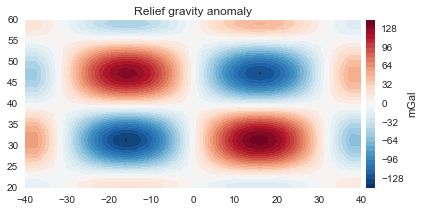

In [17]:
plt.figure(figsize=(7, 3))
plt.title('Relief gravity anomaly')
plt.axis('scaled')
plt.tricontourf(lon, lat, data, 40, cmap="RdBu_r")
plt.colorbar(pad=0.01).set_label(u'mGal')
plt.xlim(lon.min(), lon.max())
plt.ylim(lat.min(), lat.max())
plt.tight_layout()